In [2]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_quittime import RPS_quittime  
from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi
from rps_simulation import display_progress

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved


np.random.seed(10) #setting seed for reproducible results 


In [3]:

## Defining the learning, forgetting and practice functions:

# Initializing the RPS_core class:
sample_concave = RPS_quittime(learning_func = exponential_learning(alpha=0.2),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.05, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=1, 
                    quit_thresh=20, max_time=1000)


# run simulation:
sample_concave.run_simulation()




In [4]:
ps = sample_concave.practice_times
ss = sample_concave.skill_levels


In [5]:
sample_concave.quit

0

## Loop and run many sims 

Formula to set suitable $T_{th}$ quit threshold:
$$ T_{th} = \frac{\ln(N)}{\beta} $$
where, 
* $N$ = factor by which skill diminishes at quit vs. at last practice event
* $T_{th}$ = quit threshold to set in sim
* $\beta$ = forgetting rate
### 1. Exponential Case:

In [6]:
beta = 0.2;  N_factor = 100
np.log(N_factor)/beta

np.float64(23.025850929940457)

In [7]:
n_sims = 2000

quit_exp = [] # binary list storing if quit or not
n_prac_exp = [] # number of pracytice events
s_final_exp = [] # final skill
prac_final_exp = []
for i in range(n_sims):
    tmp_sim = RPS_quittime(learning_func = exponential_learning(alpha=0.2),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.2, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=1, 
                    quit_thresh=10, max_time=1000)

    tmp_sim.run_simulation()
    quit_tmp = tmp_sim.quit # quit?
    quit_exp.append(quit_tmp)
    
    n_prac_exp.append(len(tmp_sim.practice_times)-2)
    s_final_exp.append(tmp_sim.final_skill)    
    #prac_final_exp.append(tmp_sim.practice_times[-2])
    prac_final_exp.append(tmp_sim.career_length)
    
    # Display Porgressbar:
    display_progress(i+1, n_sims)

exp_quit = {'quit': quit_exp,
            'n_prac': n_prac_exp,
            's_final': s_final_exp,
            'prac_final': prac_final_exp
           } 

# Save csv file of quit data: 
df_exp_quit = pd.DataFrame(exp_quit)
df_exp_quit.head(10)
df_exp_quit.to_csv('../data/df_exp_quit.csv')

# Quit percent:
exp_quit_perc = np.round(sum(df_exp_quit['quit']==1)*100/n_sims, 2)
print('Total quit percent in exponential case: '  + str(exp_quit_perc))

Total quit percent in exponential case: 0.0


### 2. Sigmoid Case:

In [8]:
n_sims = 5000

quit_log = [] # binary list storing if quit or not
n_prac_log = [] # number of pracytice events
s_final_log = [] # final skill
prac_final_log = []  # stores career lengths
for i in range(n_sims):
    tmp_sim = RPS_quittime(learning_func = logistic_learning(alpha=0.4),
                    forgetting_func = exponential_forgetting(forgetting_rate=0.2),
                    practice_rate_func = simple_linear_rate(a=0.2, b=5),
                    waiting_time_dist = exponential_waiting_time,
                    initial_skill=0.1, initial_practice_rate=1, 
                    quit_thresh=10, max_time=1000)

    tmp_sim.run_simulation()
    quit_tmp = tmp_sim.quit # quit?
    quit_log.append(quit_tmp)
    
    n_prac_log.append(len(tmp_sim.practice_times)-2)
    s_final_log.append(tmp_sim.final_skill)    
    prac_final_log.append(tmp_sim.career_length)

    # Display Porgressbar:
    display_progress(i+1, n_sims)

# Make dict for saving:
log_quit = {'quit': quit_log,
            'n_prac': n_prac_log,
            's_final': s_final_log,
            'prac_final': prac_final_log
            }

# Save csv file of quit data: 
df_log_quit = pd.DataFrame(log_quit)
display(df_log_quit.head(5))
df_log_quit.to_csv('../data/df_log_quit.csv')

# Quit percent:
log_quit_perc = np.round(sum(df_log_quit['quit']==1)*100/n_sims, 2)
print('Total quit percent in logistic case: '  + str(log_quit_perc))

,quit,n_prac,s_final,prac_final
0,0,3544,0.832857,1000.0
1,0,3562,0.824037,1000.0
2,0,3553,0.793428,1000.0
3,0,3460,0.757244,1000.0
4,0,3556,0.890287,1000.0


Total quit percent in logistic case: 17.7


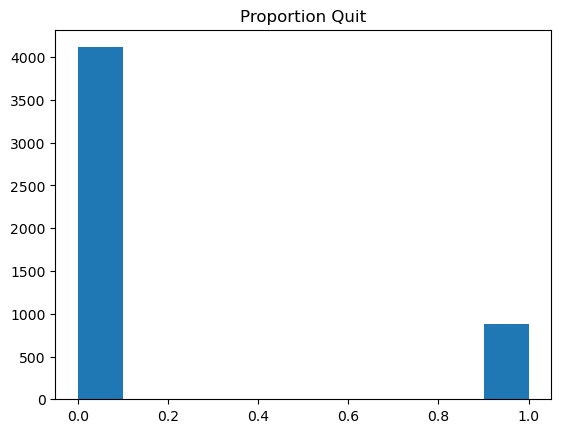

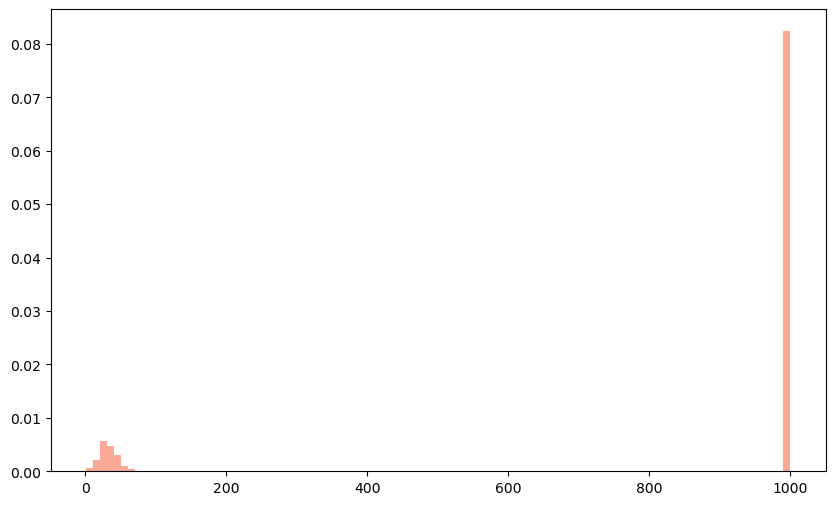

In [9]:
# df_log_quit.head(10)

plt.hist(quit_log)
plt.title('Proportion Quit')
plt.show()


# see quit times distribution
plt.figure(figsize=( 10,6))
plt.hist(prac_final_log, bins=100, density=True, alpha=0.6, color=sigmoid_colour)
plt.show()


### 3. Plot - Distribution of Career Lengths:

In [ ]:
#df_exp_quit['Learning Curve'] = 'Exponential'
df_log_quit['Learning Curve'] = 'Logistic'

df_rps_sim  = pd.concat([df_exp_quit, df_log_quit])
df_rps_sim.head()




NameError: name 'df_log_quit' is not defined

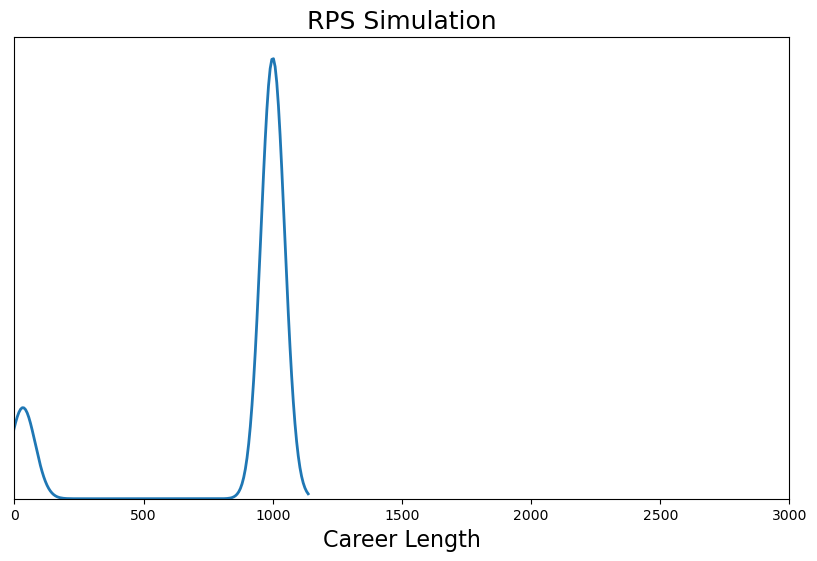

In [18]:
sigmoid_colour = '#f77150'
concave_colour = '#466be8'
max_time = 3000 # make sure it matches the simulation parameter above

plt.figure(figsize=( 10,6))
ax = sns.kdeplot(data=df_log_quit, 
            x='prac_final', 
            #hue='Learning Curve', 
            fill=False,
            alpha=1,
            linewidth=2,
            bw_adjust=0.68)
           # palette=[concave_colour, sigmoid_colour])


#sns.move_legend(ax, 'upper left')
#plt.setp(ax.get_legend().get_texts(), fontsize=12) # legend txt settings
#plt.setp(ax.get_legend().get_title(), fontsize=14) # legend title settings

plt.xlabel('Career Length', fontsize=16)
plt.ylabel('', fontsize=16)
plt.title('RPS Simulation', fontsize=18)
plt.xlim([0, max_time])
plt.yticks([])

plt.savefig('../plots/rps_sim_carlen_compare.jpg', dpi=512)
plt.show()


## 2 RPS Simulation - Hazard Rates

In [1]:
log_haz_rates = pd.read_csv('../data/sim_log_haz_rates.csv') # estimated using Muhaz R-package


NameError: name 'pd' is not defined

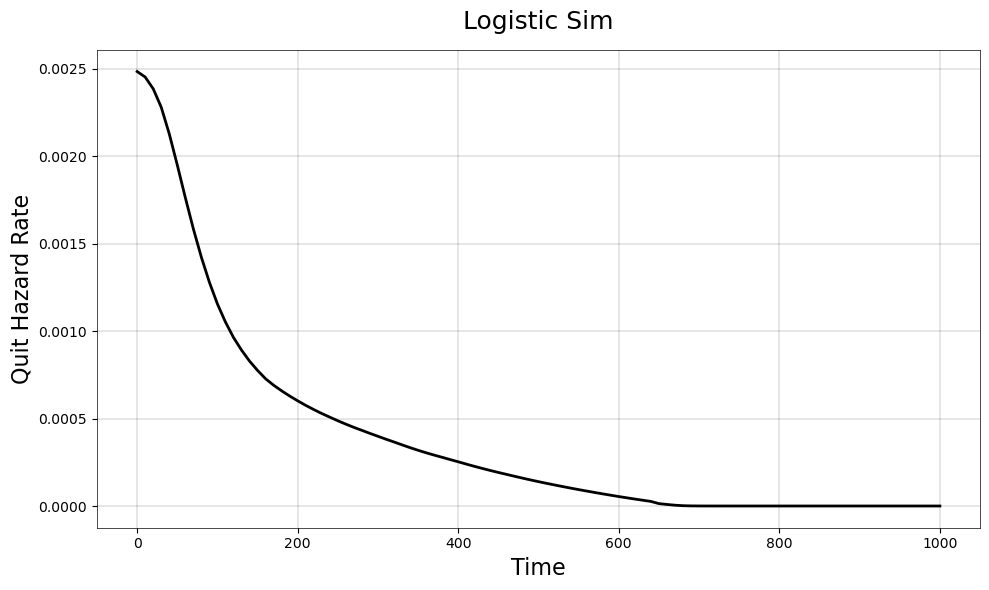

In [21]:
# Set style to white background
plt.style.use('default')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=log_haz_rates, 
            x='time', 
            y='haz_rate', 
            color='black',
            linewidth=2)

# Customize the plot
plt.title('Logistic Sim', fontsize=18, pad=15)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Quit Hazard Rate', fontsize=16)


# Customize grid
plt.grid(True, color='black', linestyle='-', linewidth=0.2, alpha=0.7)

# White background with thin black border
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.5)


# Adjust layout
plt.tight_layout()
plt.savefig('../plots/sim_log_haz_rate.jpg', dpi=612)
plt.show()